# Audio classification

In [59]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [60]:
from pathlib import Path 
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd

In [61]:
bs = 32

In [62]:
path = %pwd
path = Path(f'{path}/../data/')

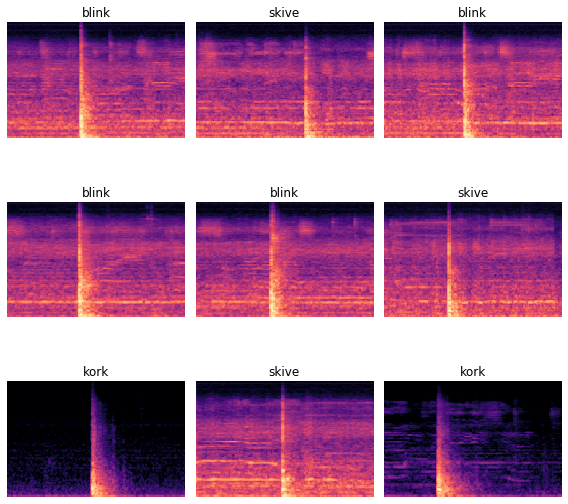

In [63]:
data = ImageDataBunch.from_folder(path, train="train_melspecs", valid='val_melspecs', ds_tfms=None, bs=bs)
data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(8,8))

In [64]:
print(data.classes) 

['blink', 'kork', 'skive']


## Training

In [65]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


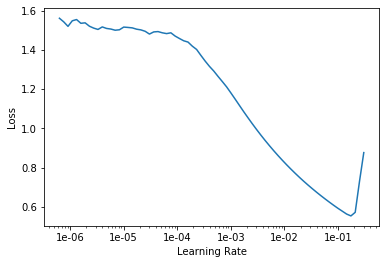

In [66]:
learn.lr_find()
learn.recorder.plot()

In [67]:
lr= 3e-2
learn.fit_one_cycle(30, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,1.339983,1.092035,0.571429,00:06
1,0.828147,0.812205,0.809524,00:04
2,0.565848,0.548566,0.761905,00:04
3,0.420598,0.385896,0.809524,00:04
4,0.347833,0.304792,0.857143,00:04
5,0.284632,0.244189,0.857143,00:04
6,0.240634,0.170480,0.904762,00:04
7,0.206413,0.104609,0.952381,00:04
8,0.180084,0.073259,0.952381,00:04
9,0.158817,0.070591,0.952381,00:04


In [68]:
learn.save('stage-1')

In [50]:
#learn.unfreeze()

In [12]:
#learn.lr_find()
#learn.recorder.plot()

In [18]:
learn.fit_one_cycle(4, slice(1e-6,lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.000125,0.095356,0.904762,00:02
1,0.013167,0.412462,0.857143,00:01
2,0.010605,1.021936,0.761905,00:01
3,0.008475,0.767439,0.809524,00:01


In [19]:
#learn.save('stage-2')

In [24]:
data = ImageDataBunch.from_folder(path, train="train_melspecs", valid='val_melspecs', ds_tfms=None, size=256, bs=bs)
data.normalize(imagenet_stats)
learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [25]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


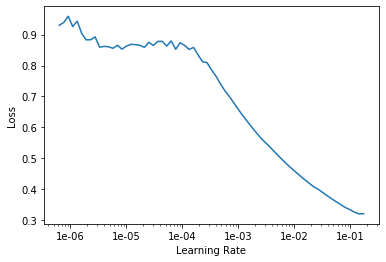

In [26]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr = 1e-2

In [30]:
learn.fit_one_cycle(30, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.006775,0.583193,0.904762,00:02
1,0.003367,0.569937,0.904762,00:02
2,0.002205,0.595346,0.904762,00:02
3,0.001623,0.621476,0.904762,00:02
4,0.001279,0.639140,0.904762,00:02
5,0.001051,0.675815,0.904762,00:02
6,0.001003,0.661208,0.904762,00:02
7,0.000861,0.661899,0.904762,00:02
8,0.000779,0.647354,0.904762,00:02
9,0.000687,0.644592,0.904762,00:02


Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
Traceback (most recent call last):
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/sathiesh/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/sathiesh/anacond

KeyboardInterrupt: 

In [18]:
learn.save('stage-3')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


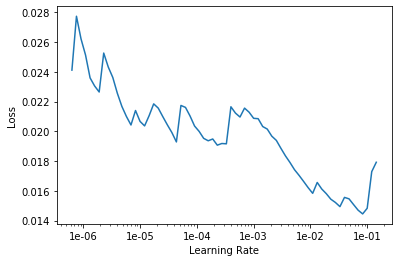

In [22]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.fit_one_cycle(1, slice(1e-4,lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.062225,0.741472,0.222222,00:02


In [16]:
learn.save('stage-4')

## Interpretation

In [51]:
learn.load('stage-1');

In [52]:
interp = ClassificationInterpretation.from_learner(learn)

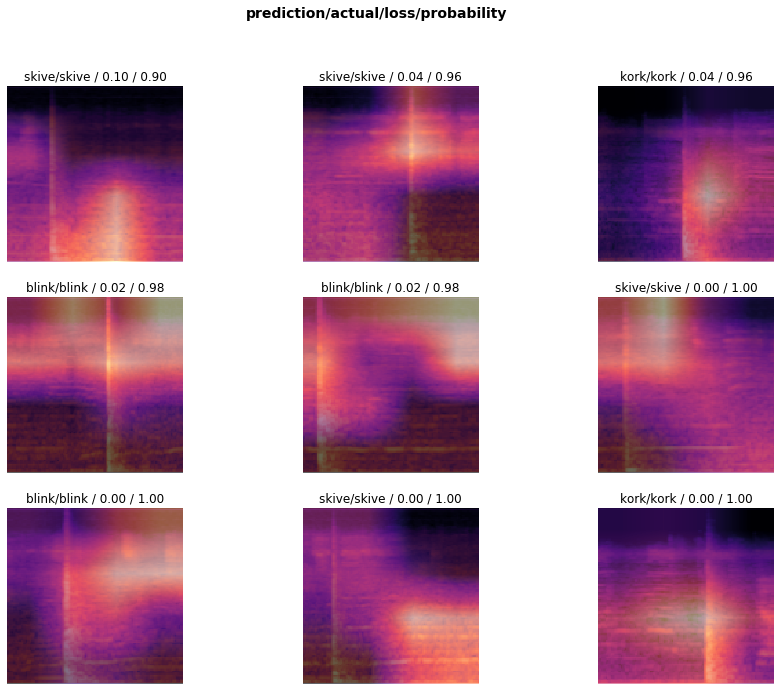

In [53]:
interp.plot_top_losses(9, figsize=(15,11))

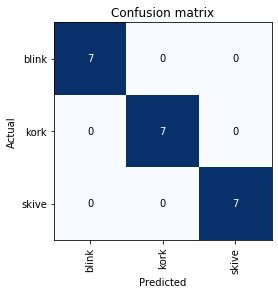

In [54]:
interp.plot_confusion_matrix()

In [56]:
interp.pred_class

tensor([0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1])

# Production model

In [58]:
learn.export()